# Visualize NS Incompressible Flow Data

This notebook visualizes the generated Navier-Stokes incompressible flow simulation data.

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import os

## Load the HDF5 Files

In [2]:
# List available HDF5 files
h5_files = [f for f in os.listdir('.') if f.endswith('.h5')]
print("Available HDF5 files:")
for f in h5_files:
    print(f"  - {f}")

Available HDF5 files:
  - ns_sim_2d_test-42.h5
  - ns_sim_2d_test-1.h5
  - ns_sim_stable-123.h5
  - ns_sim_v3-42.h5
  - ns_sim_final-42.h5
  - ns_sim_2d-1.h5


In [3]:
def load_data(filename):
    """Load data from HDF5 file and return as dict."""
    with h5py.File(filename, 'r') as f:
        data = {
            'velocity': f['velocity'][:],
            'particles': f['particles'][:],
            'force': f['force'][:],
            't': f['t'][:],
        }
        # Get config if available
        if 'config' in f.attrs:
            data['config'] = f.attrs['config']
    return data

# Load the working simulation file
filename = 'ns_sim_final-42.h5'
data = load_data(filename)

print(f"Loaded: {filename}")
print(f"  velocity shape: {data['velocity'].shape}")
print(f"  particles shape: {data['particles'].shape}")
print(f"  force shape: {data['force'].shape}")
print(f"  time steps: {data['t'].shape}")
print(f"  velocity range: [{data['velocity'].min():.4f}, {data['velocity'].max():.4f}]")
print(f"  particles range: [{data['particles'].min():.4f}, {data['particles'].max():.4f}]")

Loaded: ns_sim_final-42.h5
  velocity shape: (1, 10, 64, 64, 2)
  particles shape: (1, 10, 64, 64, 1)
  force shape: (1, 64, 64, 2)
  time steps: (1, 10)
  velocity range: [-2.6082, 2.3845]
  particles range: [-3.6801, 3.6373]


## Visualize Velocity Field (Single Frame)

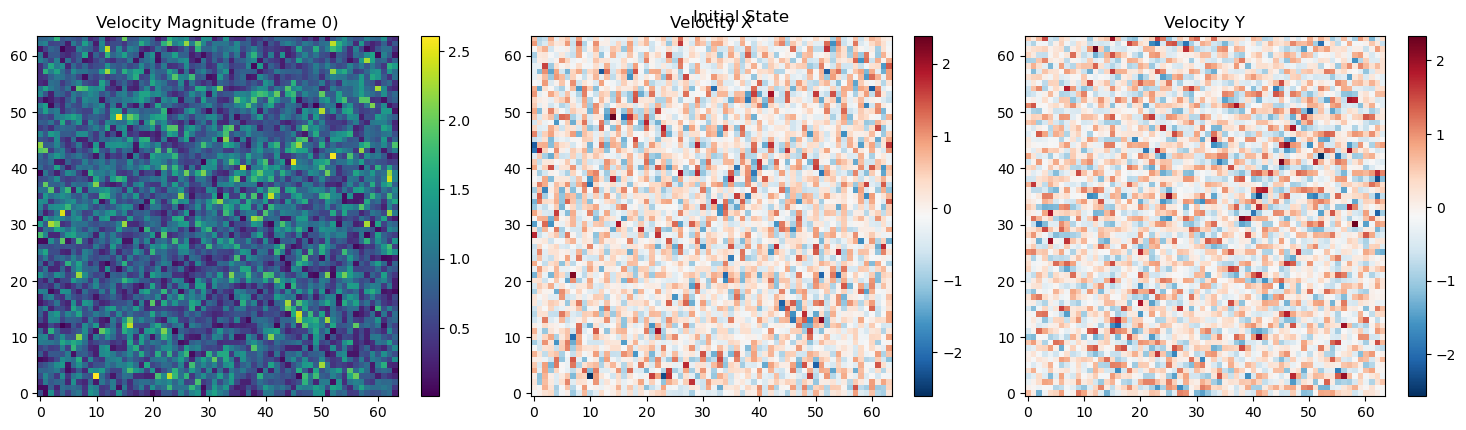

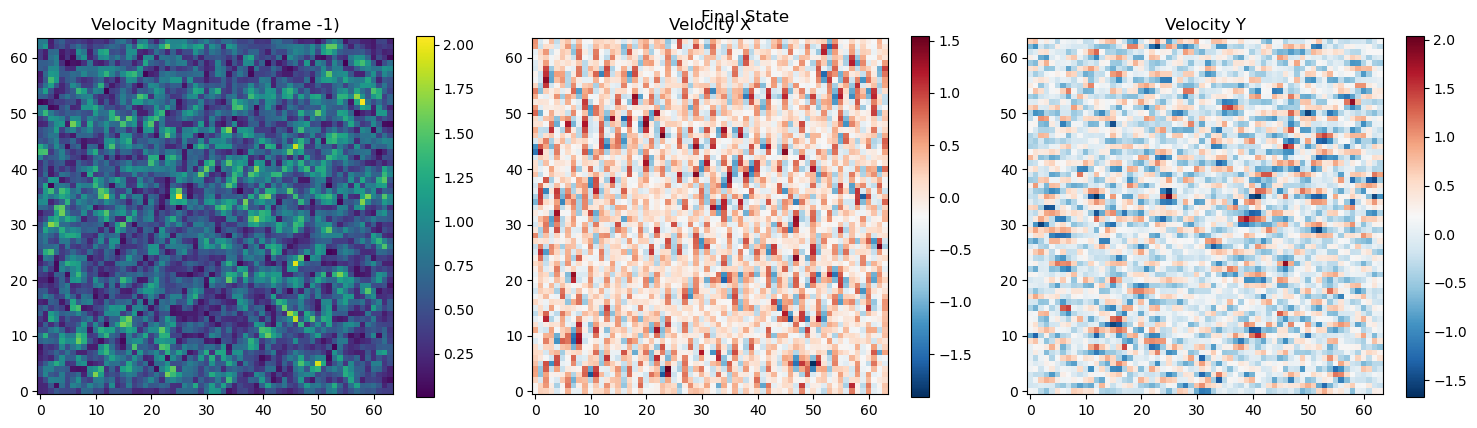

In [4]:
def plot_velocity_field(velocity, frame_idx=0, batch_idx=0):
    """Plot velocity field as quiver plot and magnitude."""
    vx = velocity[batch_idx, frame_idx, :, :, 0]
    vy = velocity[batch_idx, frame_idx, :, :, 1]
    magnitude = np.sqrt(vx**2 + vy**2)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Velocity magnitude
    im0 = axes[0].imshow(magnitude, cmap='viridis', origin='lower')
    axes[0].set_title(f'Velocity Magnitude (frame {frame_idx})')
    plt.colorbar(im0, ax=axes[0])
    
    # Velocity x-component
    im1 = axes[1].imshow(vx, cmap='RdBu_r', origin='lower')
    axes[1].set_title('Velocity X')
    plt.colorbar(im1, ax=axes[1])
    
    # Velocity y-component
    im2 = axes[2].imshow(vy, cmap='RdBu_r', origin='lower')
    axes[2].set_title('Velocity Y')
    plt.colorbar(im2, ax=axes[2])
    
    plt.tight_layout()
    return fig

# Plot first and last frame
plot_velocity_field(data['velocity'], frame_idx=0)
plt.suptitle('Initial State', y=1.02)
plt.show()

plot_velocity_field(data['velocity'], frame_idx=-1)
plt.suptitle('Final State', y=1.02)
plt.show()

## Visualize Particle Density

/tmp/ipykernel_111925/4109614936.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


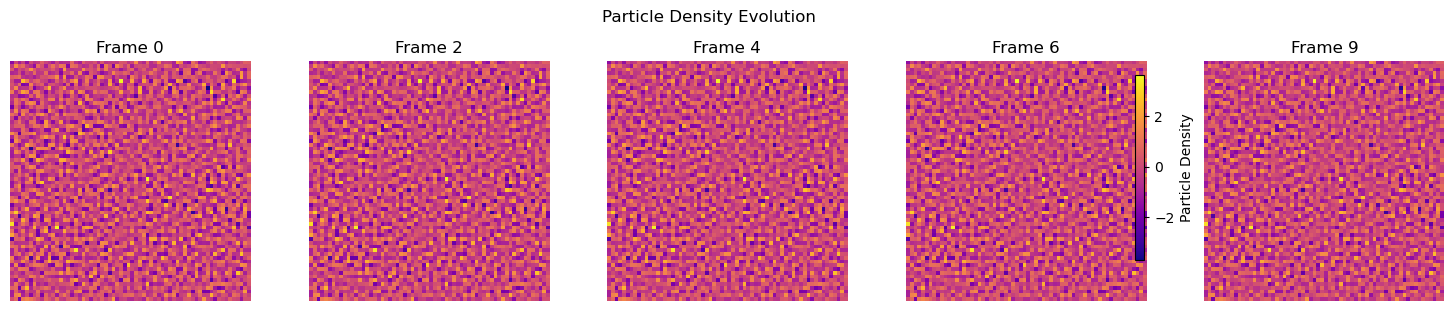

In [5]:
def plot_particles(particles, n_frames=5, batch_idx=0):
    """Plot particle density at multiple time steps."""
    total_frames = particles.shape[1]
    frame_indices = np.linspace(0, total_frames-1, n_frames, dtype=int)
    
    fig, axes = plt.subplots(1, n_frames, figsize=(3*n_frames, 3))
    
    vmin = particles[batch_idx].min()
    vmax = particles[batch_idx].max()
    
    for i, frame_idx in enumerate(frame_indices):
        p = particles[batch_idx, frame_idx, :, :, 0]
        im = axes[i].imshow(p, cmap='plasma', origin='lower', vmin=vmin, vmax=vmax)
        axes[i].set_title(f'Frame {frame_idx}')
        axes[i].axis('off')
    
    plt.colorbar(im, ax=axes, shrink=0.8, label='Particle Density')
    plt.suptitle('Particle Density Evolution', y=1.02)
    plt.tight_layout()
    return fig

plot_particles(data['particles'])
plt.show()

## Visualize External Force Field

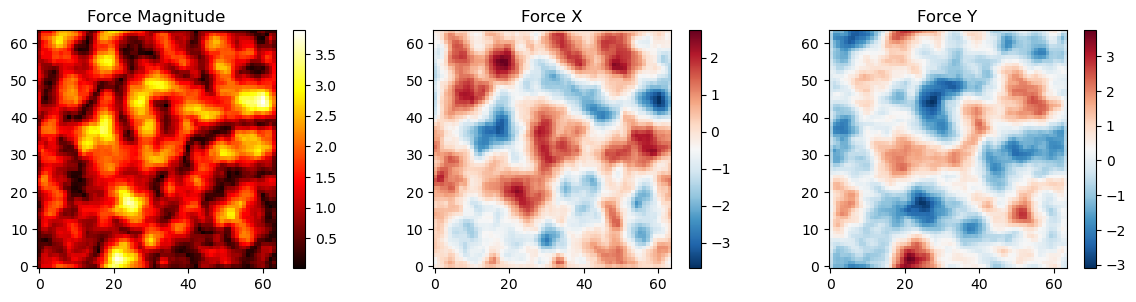

In [6]:
def plot_force(force, batch_idx=0):
    """Plot the external force field."""
    fx = force[batch_idx, :, :, 0]
    fy = force[batch_idx, :, :, 1]
    magnitude = np.sqrt(fx**2 + fy**2)
    
    fig, axes = plt.subplots(1, 3, figsize=(12, 3))
    
    im0 = axes[0].imshow(magnitude, cmap='hot', origin='lower')
    axes[0].set_title('Force Magnitude')
    plt.colorbar(im0, ax=axes[0])
    
    im1 = axes[1].imshow(fx, cmap='RdBu_r', origin='lower')
    axes[1].set_title('Force X')
    plt.colorbar(im1, ax=axes[1])
    
    im2 = axes[2].imshow(fy, cmap='RdBu_r', origin='lower')
    axes[2].set_title('Force Y')
    plt.colorbar(im2, ax=axes[2])
    
    plt.tight_layout()
    return fig

plot_force(data['force'])
plt.show()

## Animation of Flow Evolution

In [7]:
def create_animation(velocity, particles, batch_idx=0, interval=200):
    """Create animation of velocity magnitude and particle density."""
    n_frames = velocity.shape[1]
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    # Compute velocity magnitude for all frames
    vx = velocity[batch_idx, :, :, :, 0]
    vy = velocity[batch_idx, :, :, :, 1]
    vel_mag = np.sqrt(vx**2 + vy**2)
    
    # Get particle data
    part = particles[batch_idx, :, :, :, 0]
    
    # Initial plots
    im0 = axes[0].imshow(vel_mag[0], cmap='viridis', origin='lower',
                         vmin=vel_mag.min(), vmax=vel_mag.max())
    axes[0].set_title('Velocity Magnitude')
    plt.colorbar(im0, ax=axes[0])
    
    im1 = axes[1].imshow(part[0], cmap='plasma', origin='lower',
                         vmin=part.min(), vmax=part.max())
    axes[1].set_title('Particle Density')
    plt.colorbar(im1, ax=axes[1])
    
    title = fig.suptitle('Frame 0')
    
    def animate(frame):
        im0.set_array(vel_mag[frame])
        im1.set_array(part[frame])
        title.set_text(f'Frame {frame}')
        return [im0, im1, title]
    
    anim = animation.FuncAnimation(fig, animate, frames=n_frames,
                                   interval=interval, blit=True)
    plt.close(fig)
    return anim

anim = create_animation(data['velocity'], data['particles'])
HTML(anim.to_jshtml())

## Compare All Three Files

In [8]:
# Load all three files
files = ['ns_sim_2d-1.h5', 'ns_sim_2d_test-1.h5', 'ns_sim_2d_test-42.h5']
all_data = {}

for f in files:
    if os.path.exists(f):
        all_data[f] = load_data(f)
        print(f"Loaded {f}: velocity shape = {all_data[f]['velocity'].shape}")

Loaded ns_sim_2d-1.h5: velocity shape = (1, 10, 64, 64, 2)
Loaded ns_sim_2d_test-1.h5: velocity shape = (1, 10, 64, 64, 2)
Loaded ns_sim_2d_test-42.h5: velocity shape = (1, 10, 64, 64, 2)


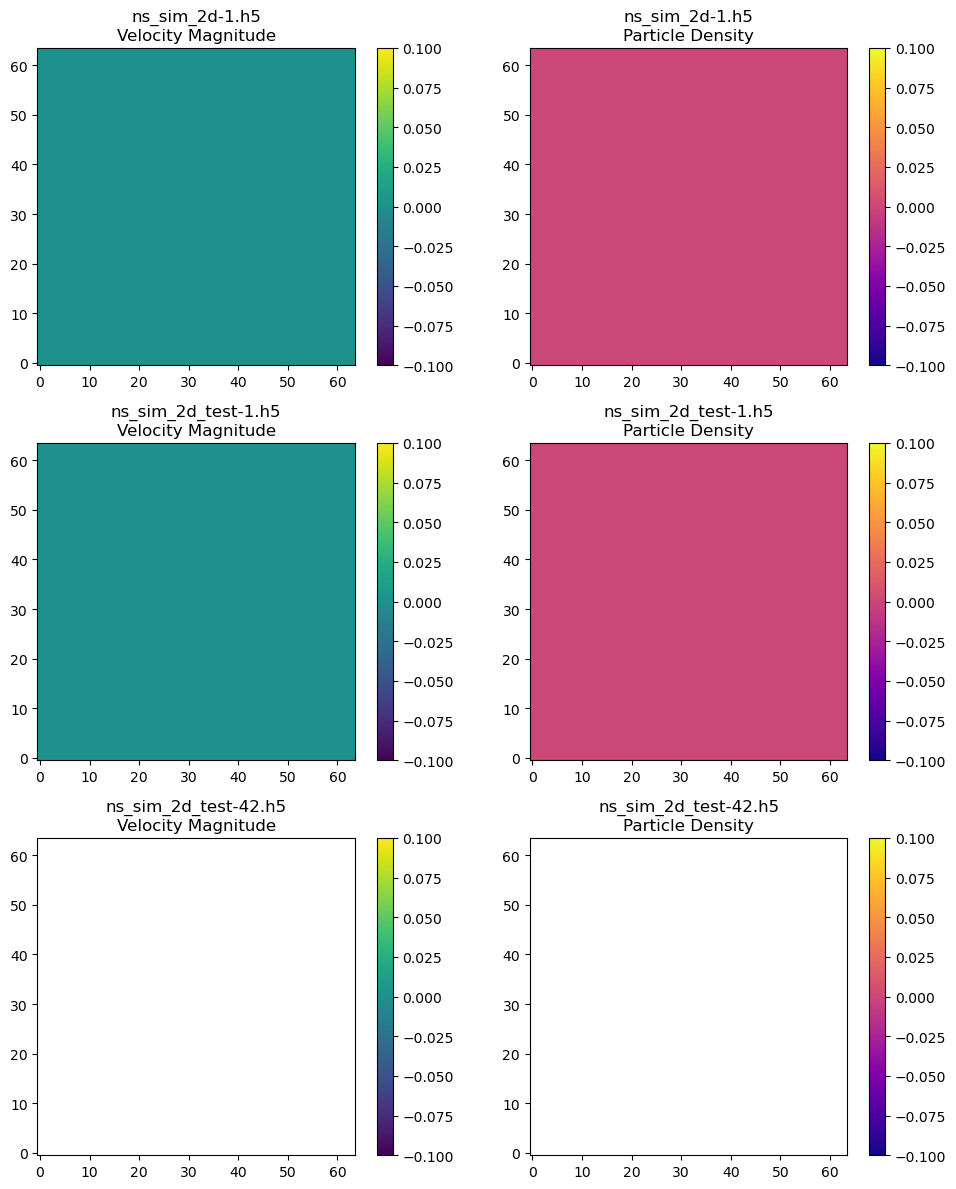

In [9]:
# Compare final states
fig, axes = plt.subplots(len(all_data), 2, figsize=(10, 4*len(all_data)))

for i, (fname, d) in enumerate(all_data.items()):
    # Velocity magnitude (final frame)
    vx = d['velocity'][0, -1, :, :, 0]
    vy = d['velocity'][0, -1, :, :, 1]
    vel_mag = np.sqrt(vx**2 + vy**2)
    
    im0 = axes[i, 0].imshow(vel_mag, cmap='viridis', origin='lower')
    axes[i, 0].set_title(f'{fname}\nVelocity Magnitude')
    plt.colorbar(im0, ax=axes[i, 0])
    
    # Particle density (final frame)
    part = d['particles'][0, -1, :, :, 0]
    im1 = axes[i, 1].imshow(part, cmap='plasma', origin='lower')
    axes[i, 1].set_title(f'{fname}\nParticle Density')
    plt.colorbar(im1, ax=axes[i, 1])

plt.tight_layout()
plt.show()